<a href="https://colab.research.google.com/github/rizomus/FIR/blob/main/IR_corr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Этап № 5 Создание финальной версии нейронной сети

## Тема: 
Вычисление импульсной характеристики 
корректирующего FIR-фильтра для эквализации акустической системы концертного зала.
___
Описание задачи:
Линейный массив - это массив акустических систем расположенных вертикально, состоит из 6 элементов (кабинетов, модулей).
В 4-х точках концертного зала измерены импульсные характеристики каждого элемента.

Задача: вычислить для каждого модуля фильтр с конечной импульсной характеристикой, таким образом, чтобы во всех точках зала амплитудная характеристика линейного массива была максимально близкой к эталонной (полученой эмпирически).

In [ ]:
from scipy.io import wavfile
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, Add, Reshape, BatchNormalization, Flatten, Dense, Lambda, Activation, Subtract
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow import unstack, convert_to_tensor, cast, add_n
from tensorflow.signal import rfft, irfft
from tensorflow.math import multiply, square
from tensorflow.math import abs as tf_abs
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import sys
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import os
from IPython.display import Audio
import librosa
import soundfile as sf
# from google.colab import drive
from random import randint, choice, random
from itertools import permutations, combinations
from tensorflow.keras.utils import plot_model
from math import ceil
import pickle

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
IR_names = os.listdir('/content/drive/MyDrive/AI University/Diplom/IR')
IR_names

['Target IR.wav',
 'Target IR (natural ph).wav',
 'p1s.wav',
 'p1c1.wav',
 'p1c2.wav',
 'p1c4.wav',
 'p1c5.wav',
 'p1hp.wav',
 'p1full.wav',
 'p2s.wav',
 'p2c1.wav',
 'p2c2.wav',
 'p2c3.wav',
 'p2c4.wav',
 'p2c5.wav',
 'p2full.wav',
 'p3s.wav',
 'p3c1.wav',
 'p3c2.wav',
 'p3c3.wav',
 'p3c4.wav',
 'p3c5.wav',
 'p3hp.wav',
 'p4s.wav',
 'p4c1.wav',
 'p4c2.wav',
 'p4c3.wav',
 'p4c4.wav',
 'p4c5.wav',
 'p4hp.wav',
 'p4full.wav',
 'p1c3.wav',
 'p3full.wav']

In [ ]:
# Линейный массив состоит из 5 ВЧ-модулей + 1 НЧ-модуль
# Измерения проводились в 4х точках зала
# В каждой точке измерялиль импульсные характеристики каждого из 6 модулей
# Пример: ключ словаря 'p1c3' - где 'p1' - первая точка 'c3' - третий модуль (кабинет), 'p1s' - НЧ модуль
# 'Target IR' - Целевая ИХ (желаемый импульс в каждой точке)

IR_dict = dict()            
for name in IR_names:

  ir, sr = librosa.load('/content/drive/MyDrive/AI University/Diplom/IR/'+name, sr=48000)
  IR_dict[name[:-4]] = ir

In [ ]:
IR_len = len(IR_dict['p1c1'])       # 4096 - длина измеренных импульсов
target_FIR_len = 512                # длина FIR-фильтра, который будем вычислять

In [ ]:
# Длина 'Target IR' должна быть равна IR_len + target_FIR_len - 1
# Поэтому дополним целевую ИХ нулями в начале

zeros = np.zeros(shape=(target_FIR_len - 1))
IR_dict['Target IR (natural ph)'] = np.append(zeros, IR_dict['Target IR (natural ph)'])

# в разных точках зала общая громкость немного отличается, 
# поэтому 'Target IR' домножается на эмпирически полученные коэффициенты соответственно

IR_dict['Target IR 1'] = IR_dict['Target IR (natural ph)'] * 2.4        
IR_dict['Target IR 2'] = IR_dict['Target IR (natural ph)'] * 2.1         
IR_dict['Target IR 3'] = IR_dict['Target IR (natural ph)'] * 1.8
IR_dict['Target IR 4'] = IR_dict['Target IR (natural ph)'] * 1.5

In [ ]:
# относительные величины задержек так же получены в ходе измерения и для каждого модуля вносятся в ручную (мс)
# задержки объясняются тем, что во-первых чисто геометрически расстояние от разных модулей до точки измерения
# немного отличается, а во-вторых в случае НЧ-кабинета дополнительная задержка обусловлена большей инерционностью НЧ-динамика

Delay_dict = dict.fromkeys(IR_dict.keys(), None)

Delay_dict['p1c1'] = 0
Delay_dict['p1c2'] = 0
Delay_dict['p1c3'] = 0.19
Delay_dict['p1c4'] = 0.79
Delay_dict['p1c5'] = 0.98
Delay_dict['p1s'] = 14.12

Delay_dict['p2c1'] = 0.04
Delay_dict['p2c2'] = 0
Delay_dict['p2c3'] = 0
Delay_dict['p2c4'] = 0.19
Delay_dict['p2c5'] = 0.31
Delay_dict['p2s'] = 20.52

Delay_dict['p3c1'] = 0.12
Delay_dict['p3c2'] = 0.04
Delay_dict['p3c3'] = 0
Delay_dict['p3c4'] = 0.02
Delay_dict['p3c5'] = 0.25
Delay_dict['p3s'] = 22.08

Delay_dict['p4c1'] = 0.21
Delay_dict['p4c2'] = 0.09
Delay_dict['p4c3'] = 0.02
Delay_dict['p4c4'] = 0
Delay_dict['p4c5'] = 0.02
Delay_dict['p4s'] = 21.29

In [ ]:
df = pd.DataFrame(columns=['Name','IR', 'Delay'])
df.IR = IR_dict.values()
df.Name = IR_dict.keys()
df.Delay = Delay_dict.values()
df

,Name,IR,Delay
0,Target IR,"[0.00038732498, 0.0005432497, 0.000575275, 0.0...",NaN
1,Target IR (natural ph),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN
2,p1s,"[-0.00016819742, -0.00018091612, -0.0001838597...",14.12
3,p1c1,"[0.0026721307, 0.0019589525, 0.0020662055, 0.0...",0.00
4,p1c2,"[-0.0031189937, -0.0013080386, -0.0022956622, ...",0.00
5,p1c4,"[0.0046901884, 0.004650438, 0.001566296, 0.002...",0.79
6,p1c5,"[0.0006220081, -0.0009945357, -0.0008319343, 0...",0.98
7,p1hp,"[-0.00010433512, -0.00498701, -0.0017318197, -...",NaN
8,p1full,"[0.0030420476, 0.00032682798, 0.0015998406, 0....",NaN
9,p2s,"[-0.0014879634, -0.0014450757, -0.0014286346, ...",20.52


In [ ]:
for name in Delay_dict.keys():              # корректировка каждого импульса с учётом задержки (дополняются нулями)
    ms = Delay_dict[name]
    if ms:
        n = round(sr * ms / 1000)
        IR_dict[name] = np.append(np.zeros(shape=(n,)), IR_dict[name][:-n])

## plot

In [ ]:
def moving_average(x, w):           # возвращает скользящее среднее массива x (w - длина окна)
    ma = np.convolve(x, np.ones(w), 'same', ) / w
    return list(ma)

In [ ]:
def smoothing(row):                         # сглаживание частотной характеристики
                                            # Идея в том, чтобы увеличивать сглаживание при движении от низких частот к высоким
    n = np.log2(len(row))                   # для этого генерируем отсчёты (frecs) по которым будем делить входной ряд на октавные полосы 
    n = ceil(n)                              
    frecs = [0] + [2**i for i in range(n+2)]    # как степени двойки [0, 2, 4, 8, 16... n], где n >= len(row)

    smoothed_bands = []                     # сюда будем складывать сглаженные полосы частот
    i = 0                                                                   # каждую полосу будем сглаживать функцией moving_average
    w = np.around(np.logspace(1, 32, num=n+3, base=1.28)).astype('int')     # при этом длина окна (w) будет разной для разных полос (логарифмически увеличивается по мере движения к высоким частотам)
    while frecs[i+1] <= len(row):                                           # параметры подобраны опытным путём
        band = row[frecs[i]:frecs[i+1]]                             # берём полосу частот
        smoothed_bands.append(moving_average(band, w[i]))               # сглаживаем её с соответствующим параметром w
        i += 1
    if frecs[i] < len(row): 
        band = row[frecs[i]:]
        smoothed_bands.append(moving_average(band, w[i]))  
    ret = []
    for sb in smoothed_bands:                                       # собираем обратно весь спектр
        ret += sb
    return np.append(row[:100], ret[100:])                      

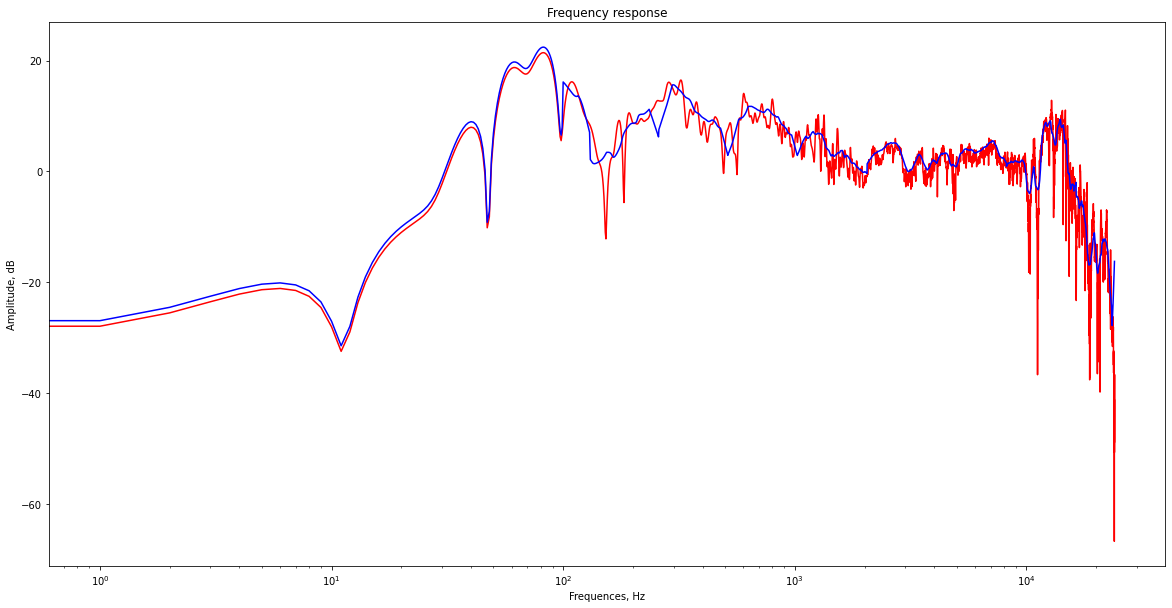

In [ ]:
def plot_frequency_response(impulse1, impulse2, smooth=1, sr=48000):           # отрисовка АЧХ 2х импульсов

    w1, h1 = signal.freqz(impulse1, worN=sr//2)      # возвращает опроные частоты (w) и их амплитуды (h) АЧХ импульса
    w2, h2 = signal.freqz(impulse2, worN=sr//2)      

    w1 = w1 * sr / 2 / np.pi                         # пересчёт частот из radians/sample в герцы
    w2 = w2 * sr / 2 / np.pi
    h1 = 20*np.log10(abs(h1))+1                      # значения амплитуды логарифмируются, для отображения в привычном масштабе
    h2 = 20*np.log10(abs(h2))

    if smooth == 2:                                  # smooth = 0 - нет сглаживания
        h1 = smoothing(h1)[:len(w1)]                 # smooth = 1 - сглаживаем только первую АЧХ
        h2 = smoothing(h2)[:len(w2)]                 # smooth = 2 - сглаживаем обе
    elif smooth == 1:
        h1 = smoothing(h1)[:len(w1)]

    fig, ax = plt.subplots(figsize = (20,10))
    ax.set_xscale('log')
    ax.set_title('Frequency response')
    ax.set_xlabel('Frequences, Hz')
    ax.set_ylabel('Amplitude, dB')
    ax.plot(w2, h2, 'r')
    ax.plot(w1, h1, 'b')
    
    plt.show()

plot_frequency_response(IR_dict['p1full'], IR_dict['p1full'])

## x_train

In [ ]:
# формируем x_train как импульсы 6-и кабинетов в 4-х точках зала, всего 24.
# y_train - 4 целевых АЧХ

x_train = np.stack([
              IR_dict['p1c1'], IR_dict['p1c2'], IR_dict['p1c3'], IR_dict['p1c4'], IR_dict['p1c5'], IR_dict['p1s'],
              IR_dict['p2c1'], IR_dict['p2c2'], IR_dict['p2c3'], IR_dict['p2c4'], IR_dict['p2c5'], IR_dict['p2s'],
              IR_dict['p3c1'], IR_dict['p3c2'], IR_dict['p3c3'], IR_dict['p3c4'], IR_dict['p3c5'], IR_dict['p3s'],
              IR_dict['p4c1'], IR_dict['p4c2'], IR_dict['p4c3'], IR_dict['p4c4'], IR_dict['p4c5'], IR_dict['p4s'],
], axis=1)
x_Scale = abs(x_train.max())            
x_train = x_train / x_Scale                     # нормализация к интервалу [-1, 1]
x_train = np.expand_dims(x_train, axis=0)

y_train = np.stack([IR_dict['Target IR 1'], IR_dict['Target IR 2'], IR_dict['Target IR 3'], IR_dict['Target IR 4']], axis=1)
y_train = np.expand_dims(y_train, axis=0)

x_train.shape, y_train.shape

((1, 4096, 24), (1, 4607, 4))

In [ ]:
def convolve_tensors(input):            # свёртка (Сначала вычисляются Z-преобразования обоих тензоров, затем они премножаются,
                                        # обратным преобразованием от полученного произведения будет являтся свёртка 2х исходных импульсов
    initial_IR = input[0]                   # исходные импульсы акустической системы
    FIR = input[1]                          # вычесленный нейронкой импульс FIR фильтра
    n = initial_IR.shape[-1]    # 24

    l1 = tf.shape(initial_IR)[-2]
    l2 = tf.shape(FIR)[-2]
    l1 = convert_to_tensor(l1)
    l2 = convert_to_tensor(l2)

    fft_length = convert_to_tensor([l1+l2-1])       # длина свёртки
    FIR = unstack(FIR, axis=-1)                     # список из 6 FIR фильтров для каждого модуля
    FIR_fft = []
    for F in FIR:
        FIR_fft.append(rfft(F, fft_length))         # Z-преобразование импульса фильтра
    FIR_fft = cast(FIR_fft, tf.complex64)

    initial_IR = unstack(initial_IR, axis=-1)       # список из (4 * 6 = 24) измеренных импульса
    
    fir_points = []                                 # список для всех 24 кабинетов

    for i in range(n):
        point_fft = rfft(initial_IR[i], fft_length)     # Z-преобразование импульса модуля
        point_fft = cast(point_fft, tf.complex64)
        mult_fft = multiply(FIR_fft[i%6], point_fft)    # произведение Z-преобразований имульсов == Z-преобразованю их свёртки
        point_with_FIR = irfft(mult_fft, fft_length)    # обратное преобразование - на выходе свётрка initial_IR с FIR

        fir_points.append(point_with_FIR)

    return K.stack(fir_points, axis=-1)         # свётрка initial_IR с FIR

In [ ]:
def Add_tensors(input):         # преобразует тензор размерностью (512, 24) в тензор с размерностью (512, 6)
                                            # путём сложения каждого шестого слоя
    stack = unstack(input, axis=-1)
    new_stack = []
    new_stack.append(add_n(stack[0::6]))
    new_stack.append(add_n(stack[1::6]))
    new_stack.append(add_n(stack[2::6]))
    new_stack.append(add_n(stack[3::6]))
    new_stack.append(add_n(stack[4::6]))
    new_stack.append(add_n(stack[5::6]))

    return K.stack(new_stack, axis=-1)

In [ ]:
'''Функция подсчёта ошибки. 
Идея в том, чтобы сравнивать не сами импульсы, а их АЧХ. Метрика - квадрат разности.
y_true - это 4 'эталонных' импульса (без учёта batch_size), которые отражают желаемое звучание всего линейного массива целиком
y_pred - 24 изначальных (измеренных) импульса 6 отдельных модулей в 4 точках зала, свёрнутые 6-ю вычеленными FIR-фильтрами
Чтобы получить импульс всего массива нужно сложить импульсы отдельных его кабинетов в соответствующих точках
АЧХ вычисляется с помощью быстрого преобразования Фурье (rfft) '''

def fft_loss(y_true, y_pred):           # shapes:    (4607, 4)     (4607, 24)

    y_true = unstack(y_true, axis=-1)           # список 4х "эталонных" импульсов
    y_pred_24 = unstack(y_pred, axis=-1)        # список 24-х изначальных импульсов, свёрнутых вычесленным FIR-фильтром
    y_pred = []
    y_pred.append(add_n(y_pred_24[:6]))             # чтобы получить суммарный импульс всего линейного массива в данной точке
    y_pred.append(add_n(y_pred_24[6:12]))           # достаточно сложить импусы всех кабинетов, т.к.
    y_pred.append(add_n(y_pred_24[12:18]))          # сумма линейных преобразований равна линейному преобразованию суммы
    y_pred.append(add_n(y_pred_24[18:]))            # len(y_pred) == len(y_true) == 4

    result = []

    for i in range(len(y_true)):                    
        r = square(tf_abs(rfft(y_true[i])) - tf_abs(rfft(y_pred[i])))   # сравниваем не сами импульсы, а их преобразования фурье, 
        result.append(r)                                                # т.е. фактически амплитудные характеристики
    return K.mean(K.stack(result, axis=-1))

## Прототип

In [ ]:
def get_model(input_shape, otput_len, activation):

    input = Input(input_shape)            # 4096, 24

    conv_1 = Conv1D(32, 8, strides=1, activation=activation, padding='same')(input)
    pool_1 = MaxPooling1D(2)(conv_1)    # 2048, 24

    conv_2 = Conv1D(32, 8, strides=1, activation=activation, padding='same')(pool_1)
    pool_2 = MaxPooling1D(2)(conv_2)    # 1024, 24

    conv_3 = Conv1D(32, 8, strides=1, activation=activation, padding='same')(pool_2)
    pool_3 = MaxPooling1D(2)(conv_3)    # 512, 24 

    FIR = Lambda(function=Add_tensors)([pool_3])            # 512, 6
    FIR = Activation('tanh')(FIR)
    convolve = Lambda(function=convolve_tensors)([input, FIR])          # свёртка исходных данных полученными фильтрами

    model_FIR = Model(input, FIR)               # модель для предикта фильтров
    model_fit = Model(input, convolve)          # модель для обучения       

    return model_FIR, model_fit 

In [ ]:
model_FIR, model_fit = get_model((IR_len, 24), 
                                 target_FIR_len, 
                                 'relu')
model_fit.compile(optimizer='Adam', loss=fft_loss)

history = model_fit.fit(x_train, y_train,
              batch_size = 24,
              epochs=100)

Epoch 1/100
1/1 [==============================] - 19s 19s/step - loss: 270.0625
Epoch 2/100
1/1 [==============================] - 0s 113ms/step - loss: 69.8676
Epoch 3/100
1/1 [==============================] - 0s 112ms/step - loss: 24.4211
Epoch 4/100
1/1 [==============================] - 0s 110ms/step - loss: 10.2297
Epoch 5/100
1/1 [==============================] - 0s 112ms/step - loss: 4.1926
Epoch 6/100
1/1 [==============================] - 0s 107ms/step - loss: 1.7921
Epoch 7/100
1/1 [==============================] - 0s 108ms/step - loss: 0.8578
Epoch 8/100
1/1 [==============================] - 0s 109ms/step - loss: 0.5609
Epoch 9/100
1/1 [==============================] - 0s 116ms/step - loss: 0.4746
Epoch 10/100
1/1 [==============================] - 0s 110ms/step - loss: 0.4639
Epoch 11/100
1/1 [==============================] - 0s 116ms/step - loss: 0.4863
Epoch 12/100
1/1 [==============================] - 0s 111ms/step - loss: 0.5115
Epoch 13/100
1/1 [===============

Добавим Dense слой, а потом вернёмся к нужной размерности через Reshape

In [ ]:
def get_model(input_shape, otput_len, activation):

    input = Input(input_shape)            # 4096, 24

    conv_1 = Conv1D(32, 8, strides=1, activation=activation, padding='same')(input)
    pool_1 = MaxPooling1D(2)(conv_1)    # 2048, 24

    conv_2 = Conv1D(32, 8, strides=1, activation=activation, padding='same')(pool_1)
    pool_2 = MaxPooling1D(2)(conv_2)    # 1024, 24

    conv_3 = Conv1D(32, 8, strides=1, activation=activation, padding='same')(pool_2)
    pool_3 = MaxPooling1D(2)(conv_3)    # 512, 24 

    flat = Flatten()(pool_3)            # 512*24
    dense = Dense(otput_len*6, activation='tanh')(flat)         # 512*6
    FIR = Reshape((otput_len, 6))(dense)       # 512, 6 - здесь 6 искомых КИХ-фильтров длиной 512
    convolve = Lambda(function=convolve_tensors)([input, FIR])          # свёртка исходных данных полученными фильтрами

    model_FIR = Model(input, FIR)               # модель для предикта фильтров
    model_fit = Model(input, convolve)          # модель для обучения       

    return model_FIR, model_fit     

In [ ]:
model_FIR, model_fit = get_model((IR_len, 24), 
                                 target_FIR_len, 
                                 'relu')
model_fit.compile(optimizer='Adam', loss=fft_loss)

In [ ]:
model_fit.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4096, 24)]   0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 4096, 32)     6176        ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 2048, 32)    0           ['conv1d_3[0][0]']               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 2048, 32)     8224        ['max_pooling1d_3[0][0]']        
                                                                                            

In [ ]:
x_train = convert_to_tensor(x_train)
y_train = convert_to_tensor(y_train)
history = model_fit.fit(x_train, y_train,
              batch_size = 24,
              epochs=100)


Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 1.6869
Epoch 2/100
1/1 [==============================] - 0s 123ms/step - loss: 910.7715
Epoch 3/100
1/1 [==============================] - 0s 119ms/step - loss: 20.1984
Epoch 4/100
1/1 [==============================] - 0s 123ms/step - loss: 27.3434
Epoch 5/100
1/1 [==============================] - 0s 122ms/step - loss: 42.5597
Epoch 6/100
1/1 [==============================] - 0s 119ms/step - loss: 32.3435
Epoch 7/100
1/1 [==============================] - 0s 121ms/step - loss: 19.8508
Epoch 8/100
1/1 [==============================] - 0s 120ms/step - loss: 11.0695
Epoch 9/100
1/1 [==============================] - 0s 127ms/step - loss: 5.7505
Epoch 10/100
1/1 [==============================] - 0s 133ms/step - loss: 3.0414
Epoch 11/100
1/1 [==============================] - 0s 126ms/step - loss: 1.6126
Epoch 12/100
1/1 [==============================] - 0s 119ms/step - loss: 0.8954
Epoch 13/100
1/1 [==============

Второй вариант показал лучшую точность

## predict

In [ ]:
FIRs = model_FIR.predict(x_train).squeeze()
FIRs = np.swapaxes(FIRs, 0, 1)
FIRs.shape

(6, 512)

In [ ]:
n = 0                       # сворачиваем исходные импульсы вычисленными КИХ-фильтрами
impuls = []                 # и складываем полученные свёртки всех модулей в каждой точке,
cab_IRs = []                # получая таким образом импульс всего массива целиом
for p in range(1,5):
    for c in range(1,6):
        s = f'p{p}c{c}'
        conv = np.convolve(IR_dict[s], FIRs[c-1])
        cab_IRs.append(conv)
    conv = np.convolve(IR_dict[f'p{p}s'], FIRs[5])
    cab_IRs.append(conv)
    impuls.append(sum(cab_IRs))
np.array(impuls).shape

(4, 4607)

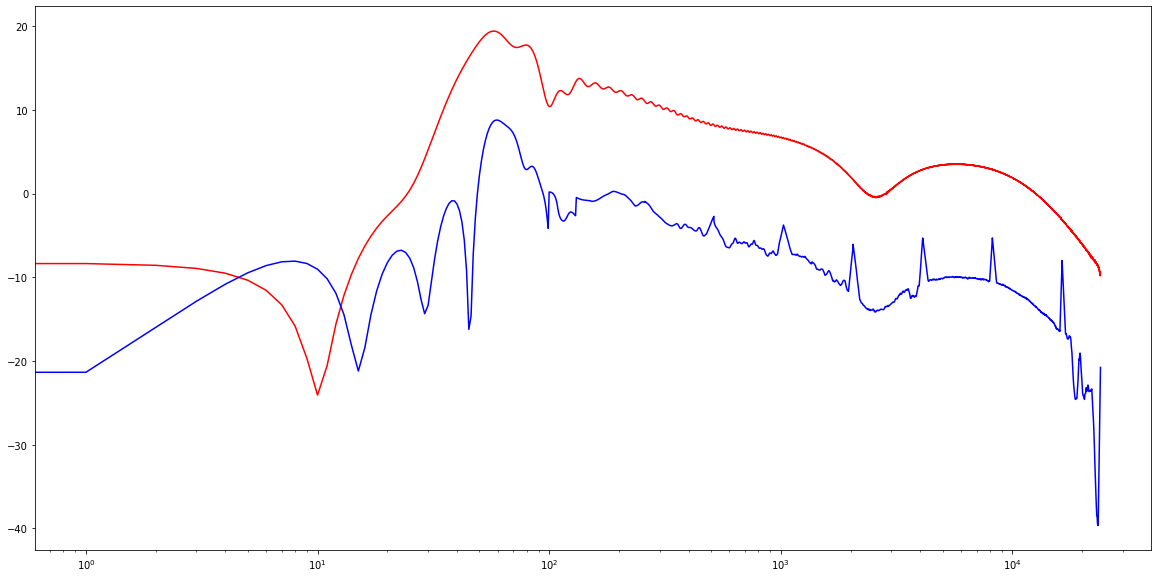

In [ ]:
plot_frequency_response(impuls[0], IR_dict['Target IR 1'], smooth=1)

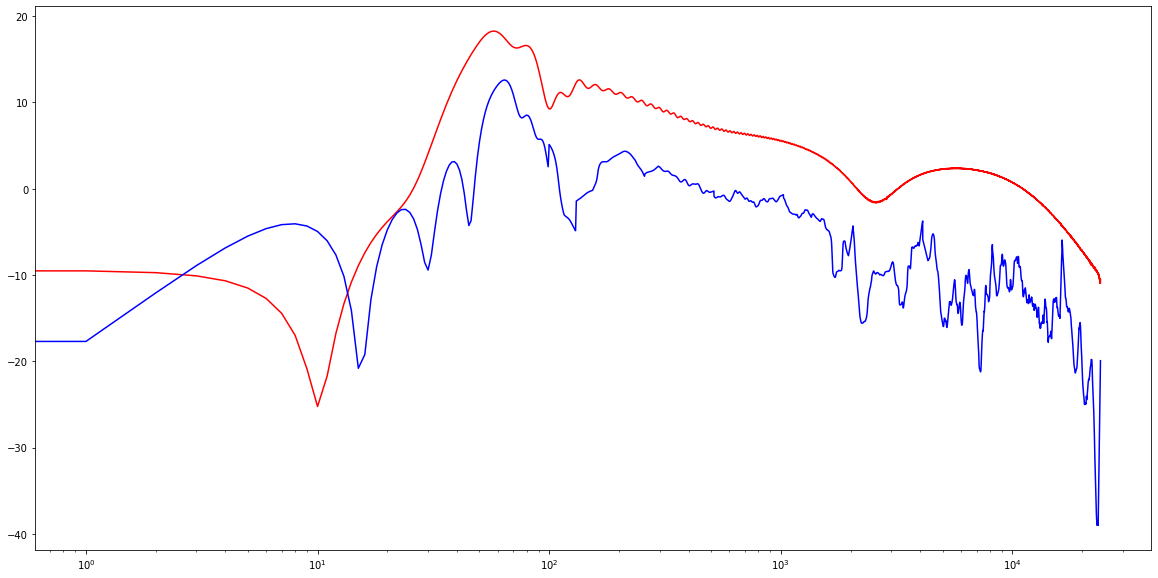

In [ ]:
plot_frequency_response(impuls[1], IR_dict['Target IR 2'], smooth=1)

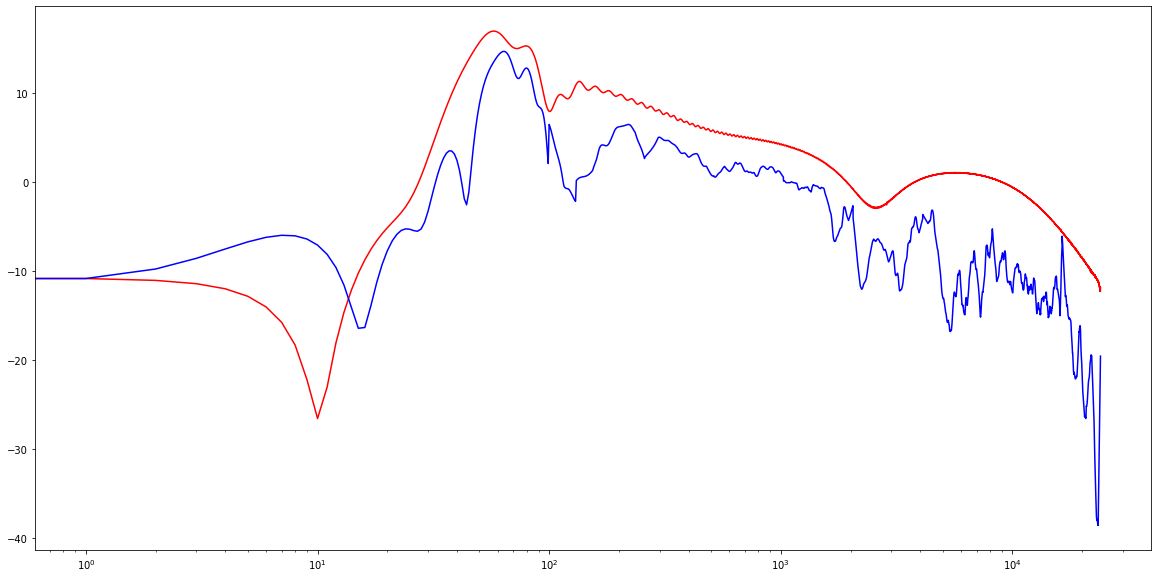

In [ ]:
plot_frequency_response(impuls[2], IR_dict['Target IR 3'], smooth=1)

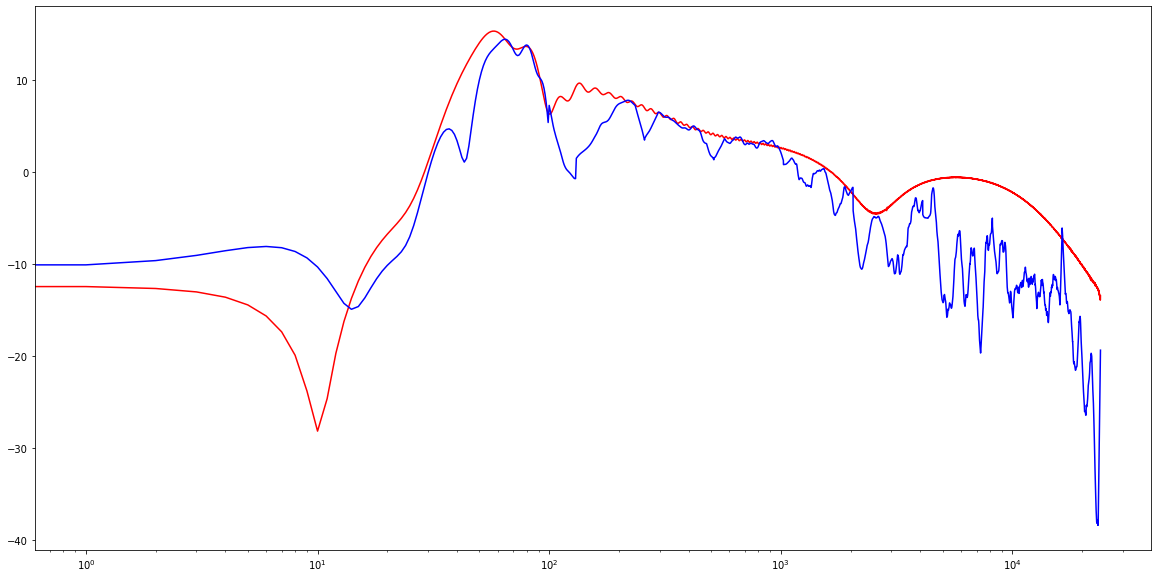

In [ ]:
plot_frequency_response(impuls[3], IR_dict['Target IR 4'], smooth=1)

Выводы:
Графики целевой и полученной АЧХ похожи. Похоже, что свёрточная сеть способна достаточно эффективно вычислять необходимый фильтр. 

Планы: 
1) Эксперименты с гиперпараметрами, возможно с архитектурой сети.
2) Исследование возможности увеличения точности с помощью генетических алгоритмов

## Генетика 1

In [ ]:
def fft_loss(y_true, y_pred):           # shapes:    (4607, 4)     (4607, 24)

    y_true = unstack(y_true, axis=-1)
    y_pred_24 = unstack(y_pred, axis=-1)
    y_pred = []
    y_pred.append(add_n(y_pred_24[:6]))             # чтобы получить суммарный импульс всего линейного массива в данной точке
    y_pred.append(add_n(y_pred_24[6:12]))           # достаточно сложить импусы всех кабинетов (сумма линейных преобразований равна линейному преобразованию суммы)
    y_pred.append(add_n(y_pred_24[12:18]))
    y_pred.append(add_n(y_pred_24[18:]))            # len(y_pred) == len(y_true) == 4
    result = []

    for i in range(len(y_true)):                    
        r = square(tf_abs(rfft(y_true[i])) - tf_abs(rfft(y_pred[i])))   # сравниваем не сами импульсы, а их преобразования фурье, 
        result.append(r)                                                # т.е. фактически амплитудные характеристики
    return K.mean(K.stack(result, axis=-1))
    

In [ ]:
def random_DNA():                   # создаёт случайный набор генов (ДНК)

    dna = [None for i in range(40)]

    dna[0] = randint(2,5)           # N_blocks

    dna[1] = randint(1,7)           # количество фильтров в первом свёрточном слое первого блока       2..128
    dna[2] = randint(4,32)          # размер ядра первого свёрточного слоя первого блока
    dna[3] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv1_activation
    dna[4] = choice([True, False])  # добалялть ли второй свёрточный слой в первый блок
    dna[5] = randint(1,7)           # количество фильтров во втором свёрточном слое первого блока       2..128
    dna[6] = randint(4,32)          # размер ядра второго свёрточного слоя первого блока
    dna[7] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv2_activation

    dna[8] = randint(1,7)           # conv1_filters        2..256
    dna[9] = randint(4,32)          # conv1_kernel
    dna[10] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv1_activation
    dna[11] = choice([True, False])  # add conv2
    dna[12] = randint(1,7)           # conv2_filters        2..256
    dna[13] = randint(4,32)          # conv2_kernel
    dna[14] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv2_activation

    dna[15] = randint(1,7)           # conv1_filters        2..256
    dna[16] = randint(4,32)          # conv1_kernel
    dna[17] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv1_activation
    dna[18] = choice([True, False])  # add conv2
    dna[19] = randint(1,7)           # conv2_filters        2..256
    dna[20] = randint(4,32)          # conv2_kernel
    dna[21] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv2_activation

    dna[22] = randint(1,7)           # conv1_filters        2..256
    dna[23] = randint(4,32)          # conv1_kernel
    dna[24] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv1_activation
    dna[25] = choice([True, False])  # add conv2
    dna[26] = randint(1,7)           # conv2_filters        2..256
    dna[27] = randint(4,32)          # conv2_kernel
    dna[28] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv2_activation

    dna[29] = randint(1,7)           # conv1_filters        2..256
    dna[30] = randint(4,32)          # conv1_kernel
    dna[31] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv1_activation
    dna[32] = choice([True, False])  # add conv2
    dna[33] = randint(1,7)           # conv2_filters        2..256
    dna[34] = randint(4,32)          # conv2_kernel
    dna[35] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # conv2_activation

    dna[36] = choice([True, False])  # добавлять ли полносвязный слой
    dna[37] = randint(8, 11)                   # количество фильтров полносвязного слоя      512..2049
    dna[38] = choice(['linear', 'relu', 'elu', 'tanh', 'sigmoid', 'softmax'])      # активация полносвязного слоя

    return dna
    

In [ ]:
def transcript_model(dna, input_shape=(4096,24), otput_len=512):       # собирает модель по данной ДНК

    N_blocks = dna[0]               # количество блоков Свёртка-Макспулинг
    add_dense = dna[36]             # добавлять ли полносвязный слой
    dense_filters = 2**dna[37]      # количество фильтров полносвязного слоя
    dense_activation = dna[38]      # активация полносвязного слоя

    input = Input(input_shape)
    x = input
    for i in range(N_blocks):

    # параметры свёрточных слоёв                    индекс dna

        conv1_filters =     2**dna[1+i*7]      # 1, 8, 15, 22, 29   
        conv1_kernel =      dna[2+i*7]         # 2, 9, 16, 23, 30
        conv1_activation =  dna[3+i*7]         # 3, 10, 17, 24, 31
        conv2 =             dna[4+i*7]         # 4, 11, 18, 25, 32
        conv2_filters =     dna[5+i*7]         # 5, 12, 19, 26, 33
        conv2_kernel =      dna[6+i*7]         # 6, 13, 20, 27, 34
        conv2_activation =  dna[7+i*7]         # 7, 14, 21, 28, 35

        x = Conv1D(conv1_filters, conv1_kernel, strides=1, activation=conv1_activation, padding='same',)(x)
        if conv2:
            x = Conv1D(conv2_filters, conv2_kernel, strides=1, activation=conv2_activation, padding='same',)(x)
        x = MaxPooling1D(2)(x)

    x = Flatten()(x) 
    if add_dense:
        x = Dense(dense_filters, dense_activation)(x)
    x = Dense(otput_len*6, activation='tanh')(x)
    FIR = Reshape((otput_len, 6))(x)
    convolve = Lambda(function=convolve_tensors)([input, FIR])
    model_FIR = Model(input, FIR)
    model_fit = Model(input, convolve)

    return model_FIR, model_fit 
    

In [ ]:
def model_accuracy(model, ep=100):              # обучает модель и возвращает loss на последней эпохе

    model_FIR, model_fit = model
    model_fit.compile(optimizer='Adam', loss=fft_loss)
    history = model_fit.fit(x_train, y_train,
              batch_size = 24,
              epochs=ep,
              verbose=0)
    return history.history['loss'][-1]
    

In [ ]:
from itertools import permutations, combinations

def recombination(parents, mut):                # Возвращает новых членов популяции, смешивая гены родителей
    comb = combinations(parents, 2)                     # все возможные комбинации родителей
    children = []
    for p1, p2 in comb:                         # для всех комбинаций родителей
        boy = [None for i in range(40)]         # создаём заготовки под новую ДНК
        girl = [None for i in range(40)]
        for i in range(len(p1)):                                                        # проходим по всем генам
            (boy[i], girl[i]) = (p1[i], p2[i]) if random() > 0.5 else (p2[i], p1[i])        # если мальчик получает ген первого родителя, то девочка ген второго
        if random() < mut:
            boy[i]  = random_DNA()[i]                   # с вероятностью mut ген заменяется на случайный
        if random() < mut:
            girl[i]  = random_DNA()[i]
        children.append(boy)
        children.append(girl)
    return children


In [ ]:
import pickle
import os
# os.mkdir('/content/drive/MyDrive/AI University/Diplom/dna/')

n_popul = 25            # размер популяции
n_surv = 5              # количество выживших
mut = 0.05              # вероятность мутации
epochs = range(100)

popul = [random_DNA() for _ in range(n_popul)]      # создаём популяцию из случайно сгенерированных ДНК

for ep in epochs:
    scores = []                                 # очки по которым оценивается каждый бот

    for dna in popul:                           # для каждого бота
        model = transcript_model(dna)           # собираем модель по его ДНК
        scores.append(model_accuracy(model))    # считаем очки (обучаем модель, смотрим loss)
    sorted_scores = sorted(scores)              # сортируем
    winners = []

    for s in sorted_scores[:n_surv]:            # вытаскиваем индексы победителей
        ind = scores.index(s)
        winners.append(popul[ind])  

    print(f'{ep}) генетическая эпоха ')
    print(f'scores: ', end='')

    for s in sorted_scores[:n_surv]:
        print(f'{s:.2f}', end = '   ')
    print()

    children = recombination(winners, mut)      # создаём новых членов популяции, скрещивая гены родителей
    popul = winners + children

    with open(f'/content/drive/MyDrive/AI University/Diplom/dna/ep({ep})popul', 'wb') as f:
        pickle.dump(popul, f)

0) генетическая эпоха 
scores: 0.04   0.04   0.05   0.05   0.06   
1) генетическая эпоха 
scores: 0.03   0.03   0.03   0.04   0.04   
2) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
3) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
4) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
5) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
6) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
7) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
8) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
9) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
10) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
11) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
12) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
13) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03   0.03   
14) генетическая эпоха 
scores: 0.03   0.03   0.03   0.03 

Похоже, что достигнут потолок возможной ошибки - 0,03.

Посмотрим на полученные генетикой модели.

In [ ]:
with open('/content/drive/MyDrive/AI University/Diplom/dna/ep(15)popul', 'rb') as f:
    popul = pickle.load(f)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4096, 24)]        0         
                                                                 
 conv1d_6 (Conv1D)           (None, 4096, 64)          26176     
                                                                 
 conv1d_7 (Conv1D)           (None, 4096, 2)           3970      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2048, 2)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 2048, 2)           90        
                                                                 
 conv1d_9 (Conv1D)           (None, 2048, 6)           282       
                                                           

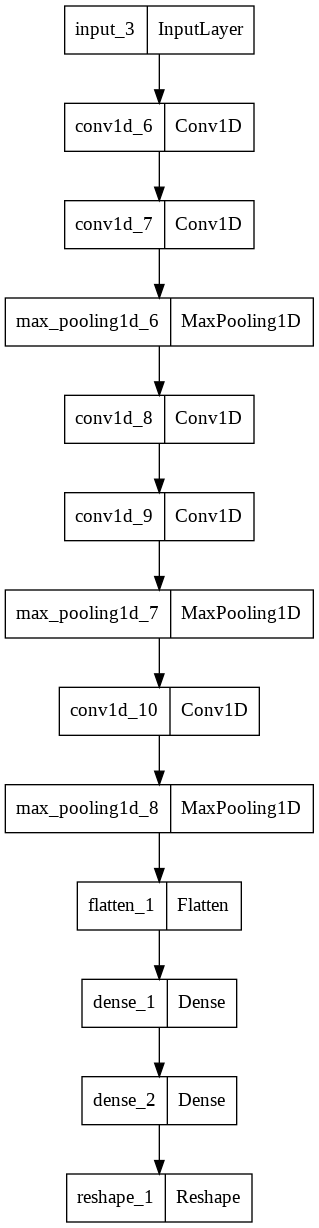

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4096, 24)]        0         
                                                                 
 conv1d_11 (Conv1D)          (None, 4096, 64)          26176     
                                                                 
 conv1d_12 (Conv1D)          (None, 4096, 2)           3970      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 2048, 2)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 2048, 2)           90        
                                                                 
 conv1d_14 (Conv1D)          (None, 2048, 6)           282       
                                                           

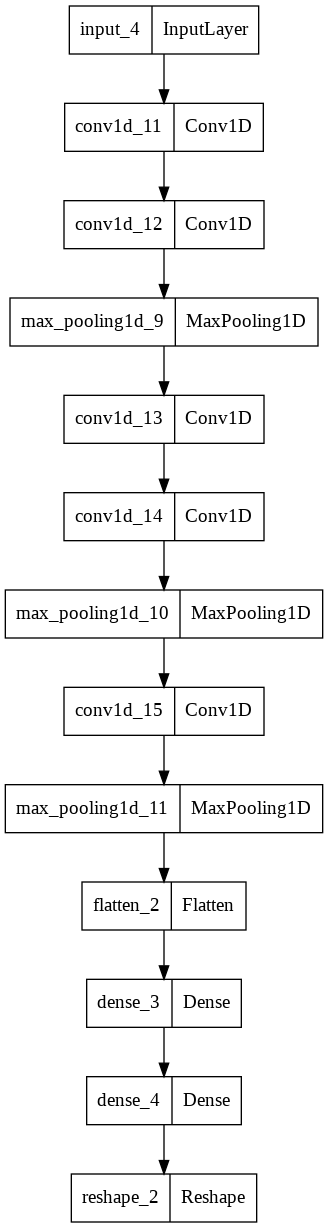

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4096, 24)]        0         
                                                                 
 conv1d_16 (Conv1D)          (None, 4096, 64)          26176     
                                                                 
 conv1d_17 (Conv1D)          (None, 4096, 2)           3970      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 2048, 2)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 2048, 2)           90        
                                                                 
 conv1d_19 (Conv1D)          (None, 2048, 5)           235       
                                                           

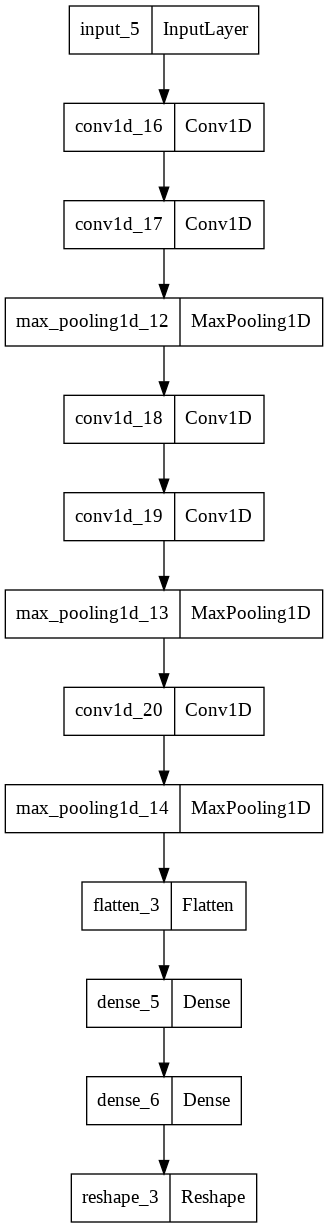

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 4096, 24)]        0         
                                                                 
 conv1d_21 (Conv1D)          (None, 4096, 64)          26176     
                                                                 
 conv1d_22 (Conv1D)          (None, 4096, 2)           3970      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 2048, 2)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 2048, 2)           90        
                                                                 
 conv1d_24 (Conv1D)          (None, 2048, 5)           235       
                                                          

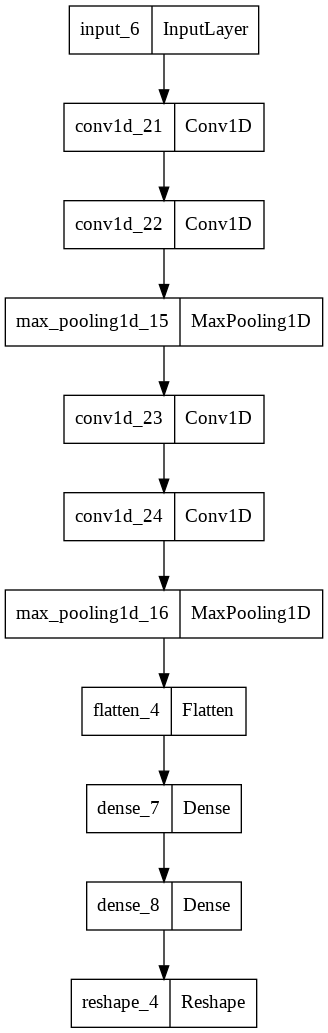

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4096, 24)]        0         
                                                                 
 conv1d_25 (Conv1D)          (None, 4096, 64)          26176     
                                                                 
 conv1d_26 (Conv1D)          (None, 4096, 2)           3970      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 2048, 2)          0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, 2048, 8)           360       
                                                                 
 conv1d_28 (Conv1D)          (None, 2048, 5)           925       
                                                          

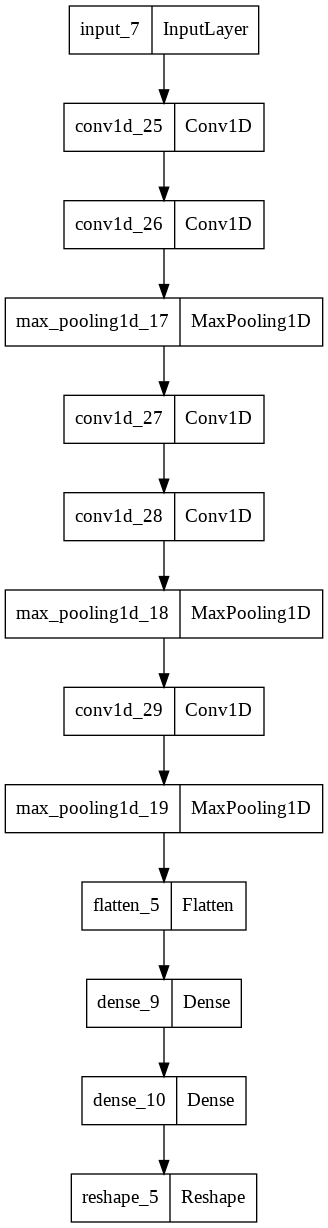

In [ ]:
for dna in popul[:5]:
    model, _ = transcript_model(dna)
    print(model.summary())
    display(plot_model(model))
    print('='*90)

Возьмём первую в списке победителей модель и посмотрим параметры слоёв

In [ ]:
dna = popul[0]
for i in range(dna[0]):

    print(f'BLOCK {i}')
    print(f'    conv1_filters =     {2**dna[1+i*7]}') 
    print(f'    conv1_kernel =      {dna[2+i*7]}')
    print(f'    conv1_activation =  {dna[3+i*7]}')
    if dna[4+i*7]:
        print()
        print(f'    conv2_filters =     {dna[5+i*7]}')
        print(f'    conv2_kernel =      {dna[6+i*7]}')
        print(f'    conv2_activation =  {dna[7+i*7]}')
    print()
if dna[36]:
    print(f'    dense_filters =     {2**dna[37]}')
    print(f'    dense_activation =  {dna[38]} ')

BLOCK 0
    conv1_filters =     64
    conv1_kernel =      17
    conv1_activation =  relu

    conv2_filters =     2
    conv2_kernel =      31
    conv2_activation =  softmax

BLOCK 1
    conv1_filters =     2
    conv1_kernel =      22
    conv1_activation =  elu

    conv2_filters =     6
    conv2_kernel =      23
    conv2_activation =  softmax

BLOCK 2
    conv1_filters =     16
    conv1_kernel =      17
    conv1_activation =  softmax

    dense_filters =     2048
    dense_activation =  softmax 


Обучим модель, используя разные оптимизаторы

In [ ]:
model_FIR, model_fit = transcript_model(dna)

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD

In [ ]:
opt = Adam(learning_rate=0.001)
model_fit.compile(optimizer=opt, loss=fft_loss, )
history = model_fit.fit(x_train, y_train,
            batch_size = 24,
            epochs=100,
            verbose=0)
print(history.history['loss'][-1])


0.038028452545404434


In [ ]:
opt = RMSprop(learning_rate=0.001)
model_fit.compile(optimizer=opt, loss=fft_loss, )
history = model_fit.fit(x_train, y_train,
            batch_size = 24,
            epochs=100,
            verbose=0)
print(history.history['loss'][-1])

0.057112112641334534


In [ ]:
opt = Adadelta(learning_rate=0.001)
model_fit.compile(optimizer=opt, loss=fft_loss, )
history = model_fit.fit(x_train, y_train,
            batch_size = 24,
            epochs=100,
            verbose=0)
print(history.history['loss'][-1])

0.04920037463307381


In [ ]:
opt = SGD(learning_rate=0.001)
model_fit.compile(optimizer=opt, loss=fft_loss, )
history = model_fit.fit(x_train, y_train,
            batch_size = 24,
            epochs=100,
            verbose=0)
print(history.history['loss'][-1])

0.042858246713876724


Adam показал лучшие результаты. Обучим ещё раз, возьмём больше эпох.

Epoch 1/300
1/1 [==============================] - 7s 7s/step - loss: 0.0306
Epoch 2/300
1/1 [==============================] - 0s 121ms/step - loss: 0.1159
Epoch 3/300
1/1 [==============================] - 0s 118ms/step - loss: 0.0408
Epoch 4/300
1/1 [==============================] - 0s 119ms/step - loss: 0.0855
Epoch 5/300
1/1 [==============================] - 0s 121ms/step - loss: 0.0625
Epoch 6/300
1/1 [==============================] - 0s 119ms/step - loss: 0.0468
Epoch 7/300
1/1 [==============================] - 0s 119ms/step - loss: 0.0534
Epoch 8/300
1/1 [==============================] - 0s 120ms/step - loss: 0.0519
Epoch 9/300
1/1 [==============================] - 0s 119ms/step - loss: 0.0537
Epoch 10/300
1/1 [==============================] - 0s 129ms/step - loss: 0.0463
Epoch 11/300
1/1 [==============================] - 0s 117ms/step - loss: 0.0449
Epoch 12/300
1/1 [==============================] - 0s 120ms/step - loss: 0.0443
Epoch 13/300
1/1 [======================

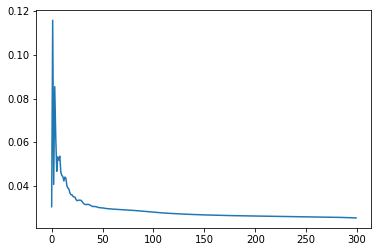

In [ ]:
opt = Adam(learning_rate=0.001)
model_fit.compile(optimizer=opt, loss=fft_loss, )
history = model_fit.fit(x_train, y_train,
            batch_size = 24,
            epochs=300,
            verbose=1)
plt.plot(history.history['loss'])
plt.show()

Уменьшим шаг обучения

Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 0.0245
Epoch 2/200
1/1 [==============================] - 0s 121ms/step - loss: 0.0245
Epoch 3/200
1/1 [==============================] - 0s 125ms/step - loss: 0.0251
Epoch 4/200
1/1 [==============================] - 0s 117ms/step - loss: 0.0246
Epoch 5/200
1/1 [==============================] - 0s 122ms/step - loss: 0.0247
Epoch 6/200
1/1 [==============================] - 0s 117ms/step - loss: 0.0248
Epoch 7/200
1/1 [==============================] - 0s 117ms/step - loss: 0.0246
Epoch 8/200
1/1 [==============================] - 0s 120ms/step - loss: 0.0245
Epoch 9/200
1/1 [==============================] - 0s 120ms/step - loss: 0.0246
Epoch 10/200
1/1 [==============================] - 0s 119ms/step - loss: 0.0246
Epoch 11/200
1/1 [==============================] - 0s 125ms/step - loss: 0.0246
Epoch 12/200
1/1 [==============================] - 0s 117ms/step - loss: 0.0245
Epoch 13/200
1/1 [======================

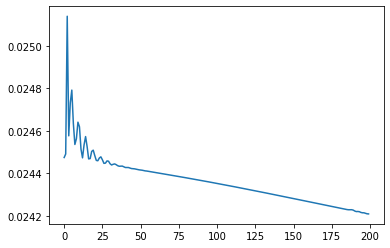

In [ ]:
opt = Adam(learning_rate=0.0001)
model_fit.compile(optimizer=opt, loss=fft_loss, )
history = model_fit.fit(x_train, y_train,
            batch_size = 24,
            epochs=200,
            verbose=1)
plt.plot(history.history['loss'])
plt.show()

Дальнейшее обучение считаю нецелесообразным, т.к. улучшение ошибки незначительно

In [ ]:
# достанем искомые 6 FIR-фильтров из предикта
# после чего вычислим АЧХ всего линейного массива в каждой точке (всего 4)

FIRs = model_FIR.predict(x_train).squeeze()
FIRs = np.swapaxes(FIRs, 0, 1)
FIRs.shape

n = 0                       # сворачиваем исходные импульсы вычисленными КИХ-фильтрами
impuls = []                 # и складываем полученные свёртки всех модулей в каждой точке,
cab_IRs = []                # получая таким образом импульс всего массива целиом
for p in range(1,5):
    for c in range(1,6):
        s = f'p{p}c{c}'
        conv = np.convolve(IR_dict[s], FIRs[c-1])
        cab_IRs.append(conv)
    conv = np.convolve(IR_dict[f'p{p}s'], FIRs[5])
    cab_IRs.append(conv)
    impuls.append(sum(cab_IRs))
np.array(impuls).shape              

(4, 4607)

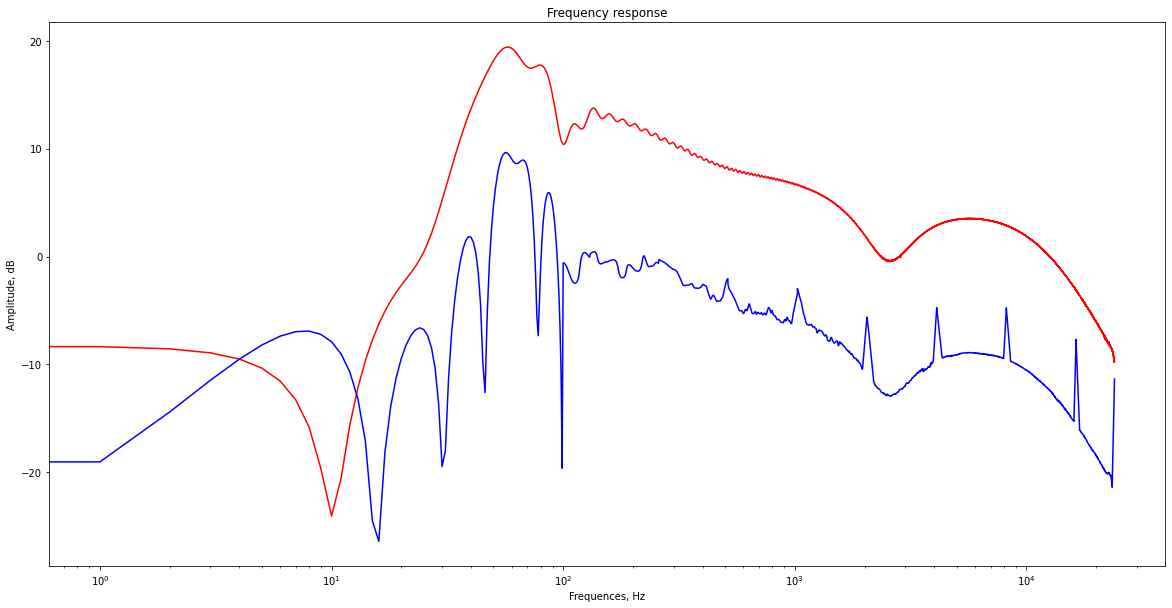

In [ ]:
plot_frequency_response(impuls[0], IR_dict['Target IR 1'], smooth=1)

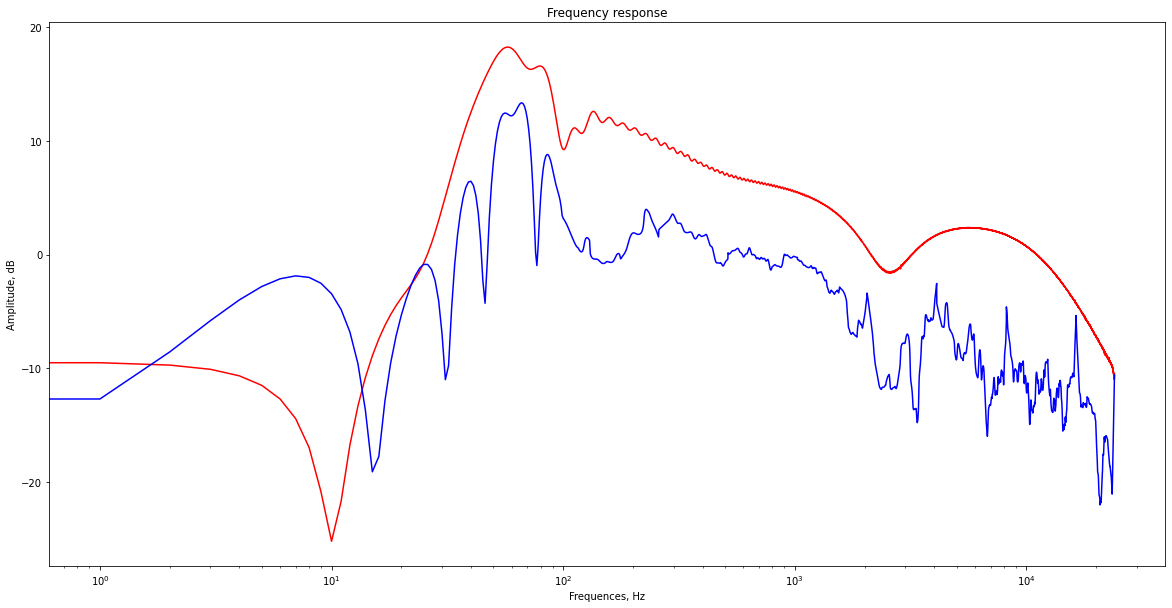

In [ ]:
plot_frequency_response(impuls[1], IR_dict['Target IR 2'], smooth=1)

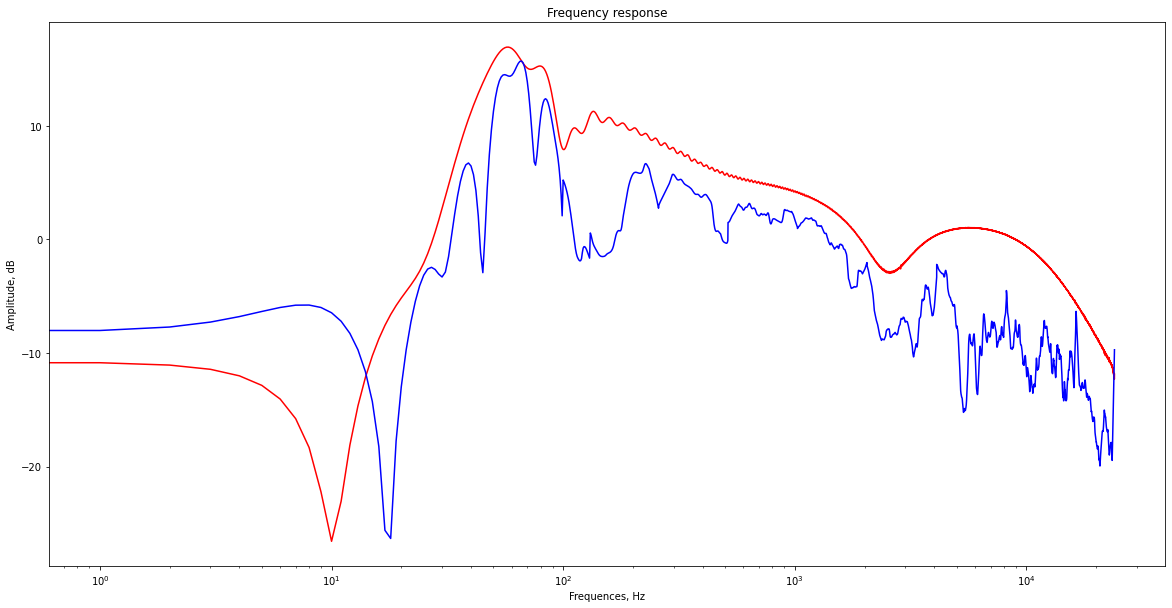

In [ ]:
plot_frequency_response(impuls[2], IR_dict['Target IR 3'], smooth=1)

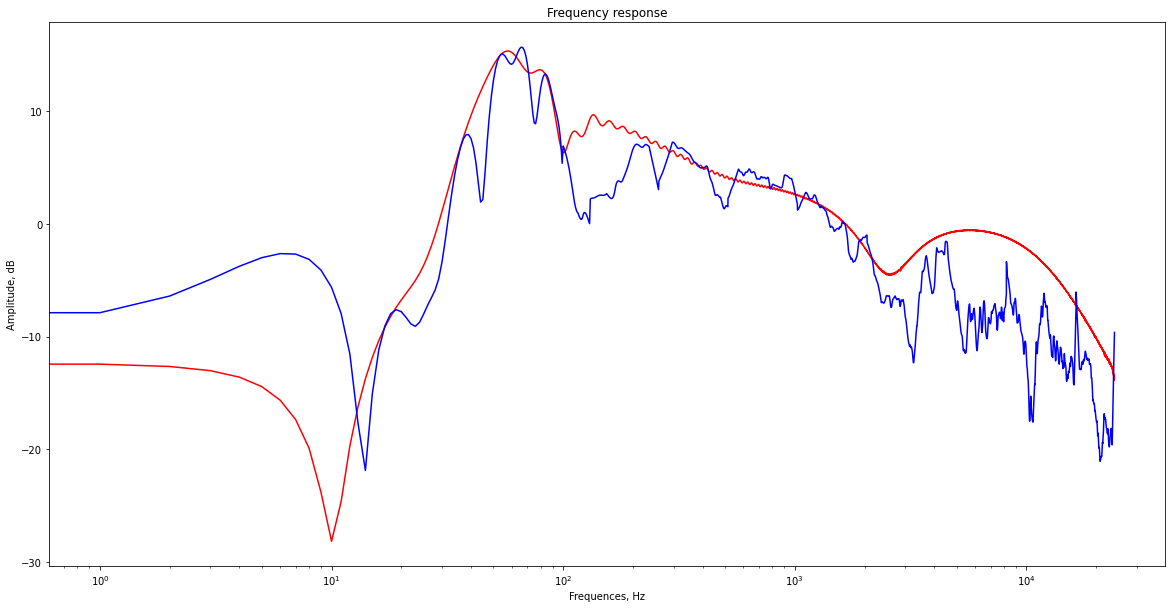

In [ ]:
plot_frequency_response(impuls[3], IR_dict['Target IR 4'], smooth=1)

## ВЫВОДЫ

С помощью свёрточной сети и генетического алгоритма удалось достичь неплохих результатов вычисления FIR-фильтра.

Для первой точки результаты близки к идеальным. Гребенчатая фильтрация на частотах ниже 100 Гц предположительно объясняется неустранимой интерфененцией прямого и отражённого от пола (и возможно стен) сигнала. Выбросы в высокочастотной области объясняются артефактами сглаживания.

В точках 2, 3 и 4 наблюдается менее точное попадание в целевую АЧХ на частотах выше 1 кГц, что объясняется большим расстоянием микрофона от линейного массива, а следовательно постепенным изменением пропорции прямого и отражённого сигнала в пользу отражённого и, как следствие, возрастанием эффектов интерференции и гармонических искажений, что в принципе делает цель труднодостижимой.

Однако во всех точках наблюдаются характерные черты целевой АЧХ: горб на 60 Гц, небольшой провал на 100 - 150 Гц, далее плавный спад к 3 кГц и дополнительный провал в этой полосе, и небольшая коррекция на ВЧ.